In [1]:
%config InlineBackend.figure_format = 'retina' 

from SLens import analyser,load_MICE, ReConc_loader

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Setting the truth

In [2]:
num = 5
alpha = np.linspace(1.0,1.8,num)
gamma = np.linspace(.8,1.8,num)
Alpha = np.round(np.repeat(alpha,5),2)
Gamma = np.round(np.tile(gamma,5),2)

In [3]:
h = .7
sample_num = 10000
datMICE = load_MICE()
ReConc = ReConc_loader()
ind = np.arange(len(datMICE.Mstar_arr))
np.random.shuffle(ind)
Mh = datMICE.Mh_arr-np.log10(h) 
Mstar = datMICE.Mstar_arr-np.log10(h)
zlens = datMICE.zlens_arr
Re = ReConc.Re_arr
Conc = ReConc.Conc_arr
Mh = Mh[ind][:sample_num]
Mstar = Mstar[ind][:sample_num]
zlens = zlens[ind][:sample_num]
Re = Re[ind][:sample_num]
c = Conc[ind][:sample_num]

palette = {"Lenses":'lightsteelblue','MICE':'bisque'}    
Re = np.log10(Re)
dat = np.fromfile("../Downloads/GLens1/GLens_para/lenses_all/r{}_alpha{}.bin".format(1.2,1.3),dtype='f8').reshape(-1,8)
ind = np.arange(len(dat))
np.random.shuffle(ind)
dat = dat[ind][:sample_num]
Einsrad = dat[:,5]
ind = np.arange(len(dat))
kind = np.zeros(len(dat)+len(Mh))
kind[-len(c):] = np.ones(len(c))
d = {r'$\log\,M_{200}$':np.concatenate((dat[:,0]-np.log10(h),Mh),axis=None),r'$\log\,M_{*}$':np.concatenate((dat[:,1]-np.log10(h),Mstar),axis=None),r'$z_{L}$':np.concatenate((dat[:,2],zlens),axis=None),r'$c$':np.concatenate((dat[:,3],c),axis=None),r'$\log\,R_e$':np.concatenate((dat[:,4],Re),axis=None),'kind':kind}

df = pd.DataFrame(data=d)
df = df.replace(1,'MICE')
df = df.replace(0,'Lenses')

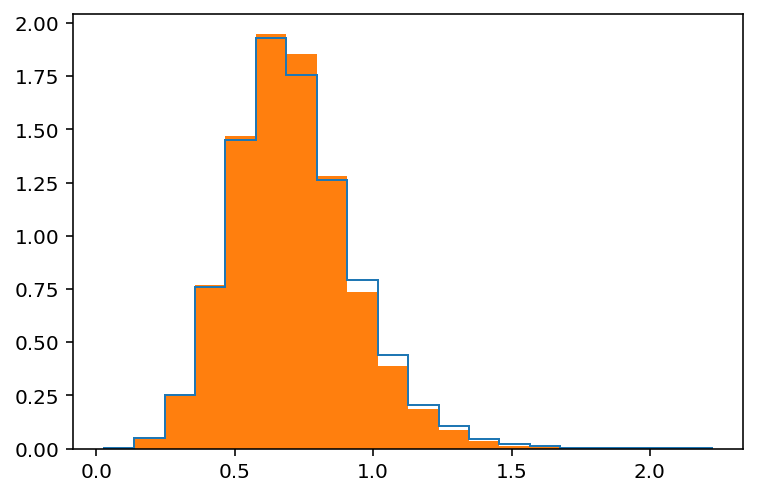

In [4]:
dat = np.fromfile("../Downloads/GLens1/GLens_para/lenses_all/r{}_alpha{}.bin".format(1.2,1.3),dtype='f8').reshape(-1,8)
ReConc = ReConc_loader()
ind = np.arange(len(datMICE.Mstar_arr))
np.random.shuffle(ind)
Mh = datMICE.Mh_arr-np.log10(h) 
Mstar = datMICE.Mstar_arr-np.log10(h)
zlens = datMICE.zlens_arr
Re = ReConc.Re_arr

plt.figure(figsize=(6,4))
plt.hist(np.log10(Re),bins=np.linspace(np.log10(Re).min(),np.log10(Re).max(),21),histtype='step',density=True)
plt.hist(dat[:,4],bins=np.linspace(np.log10(Re).min(),np.log10(Re).max(),21),density=True)
plt.show()

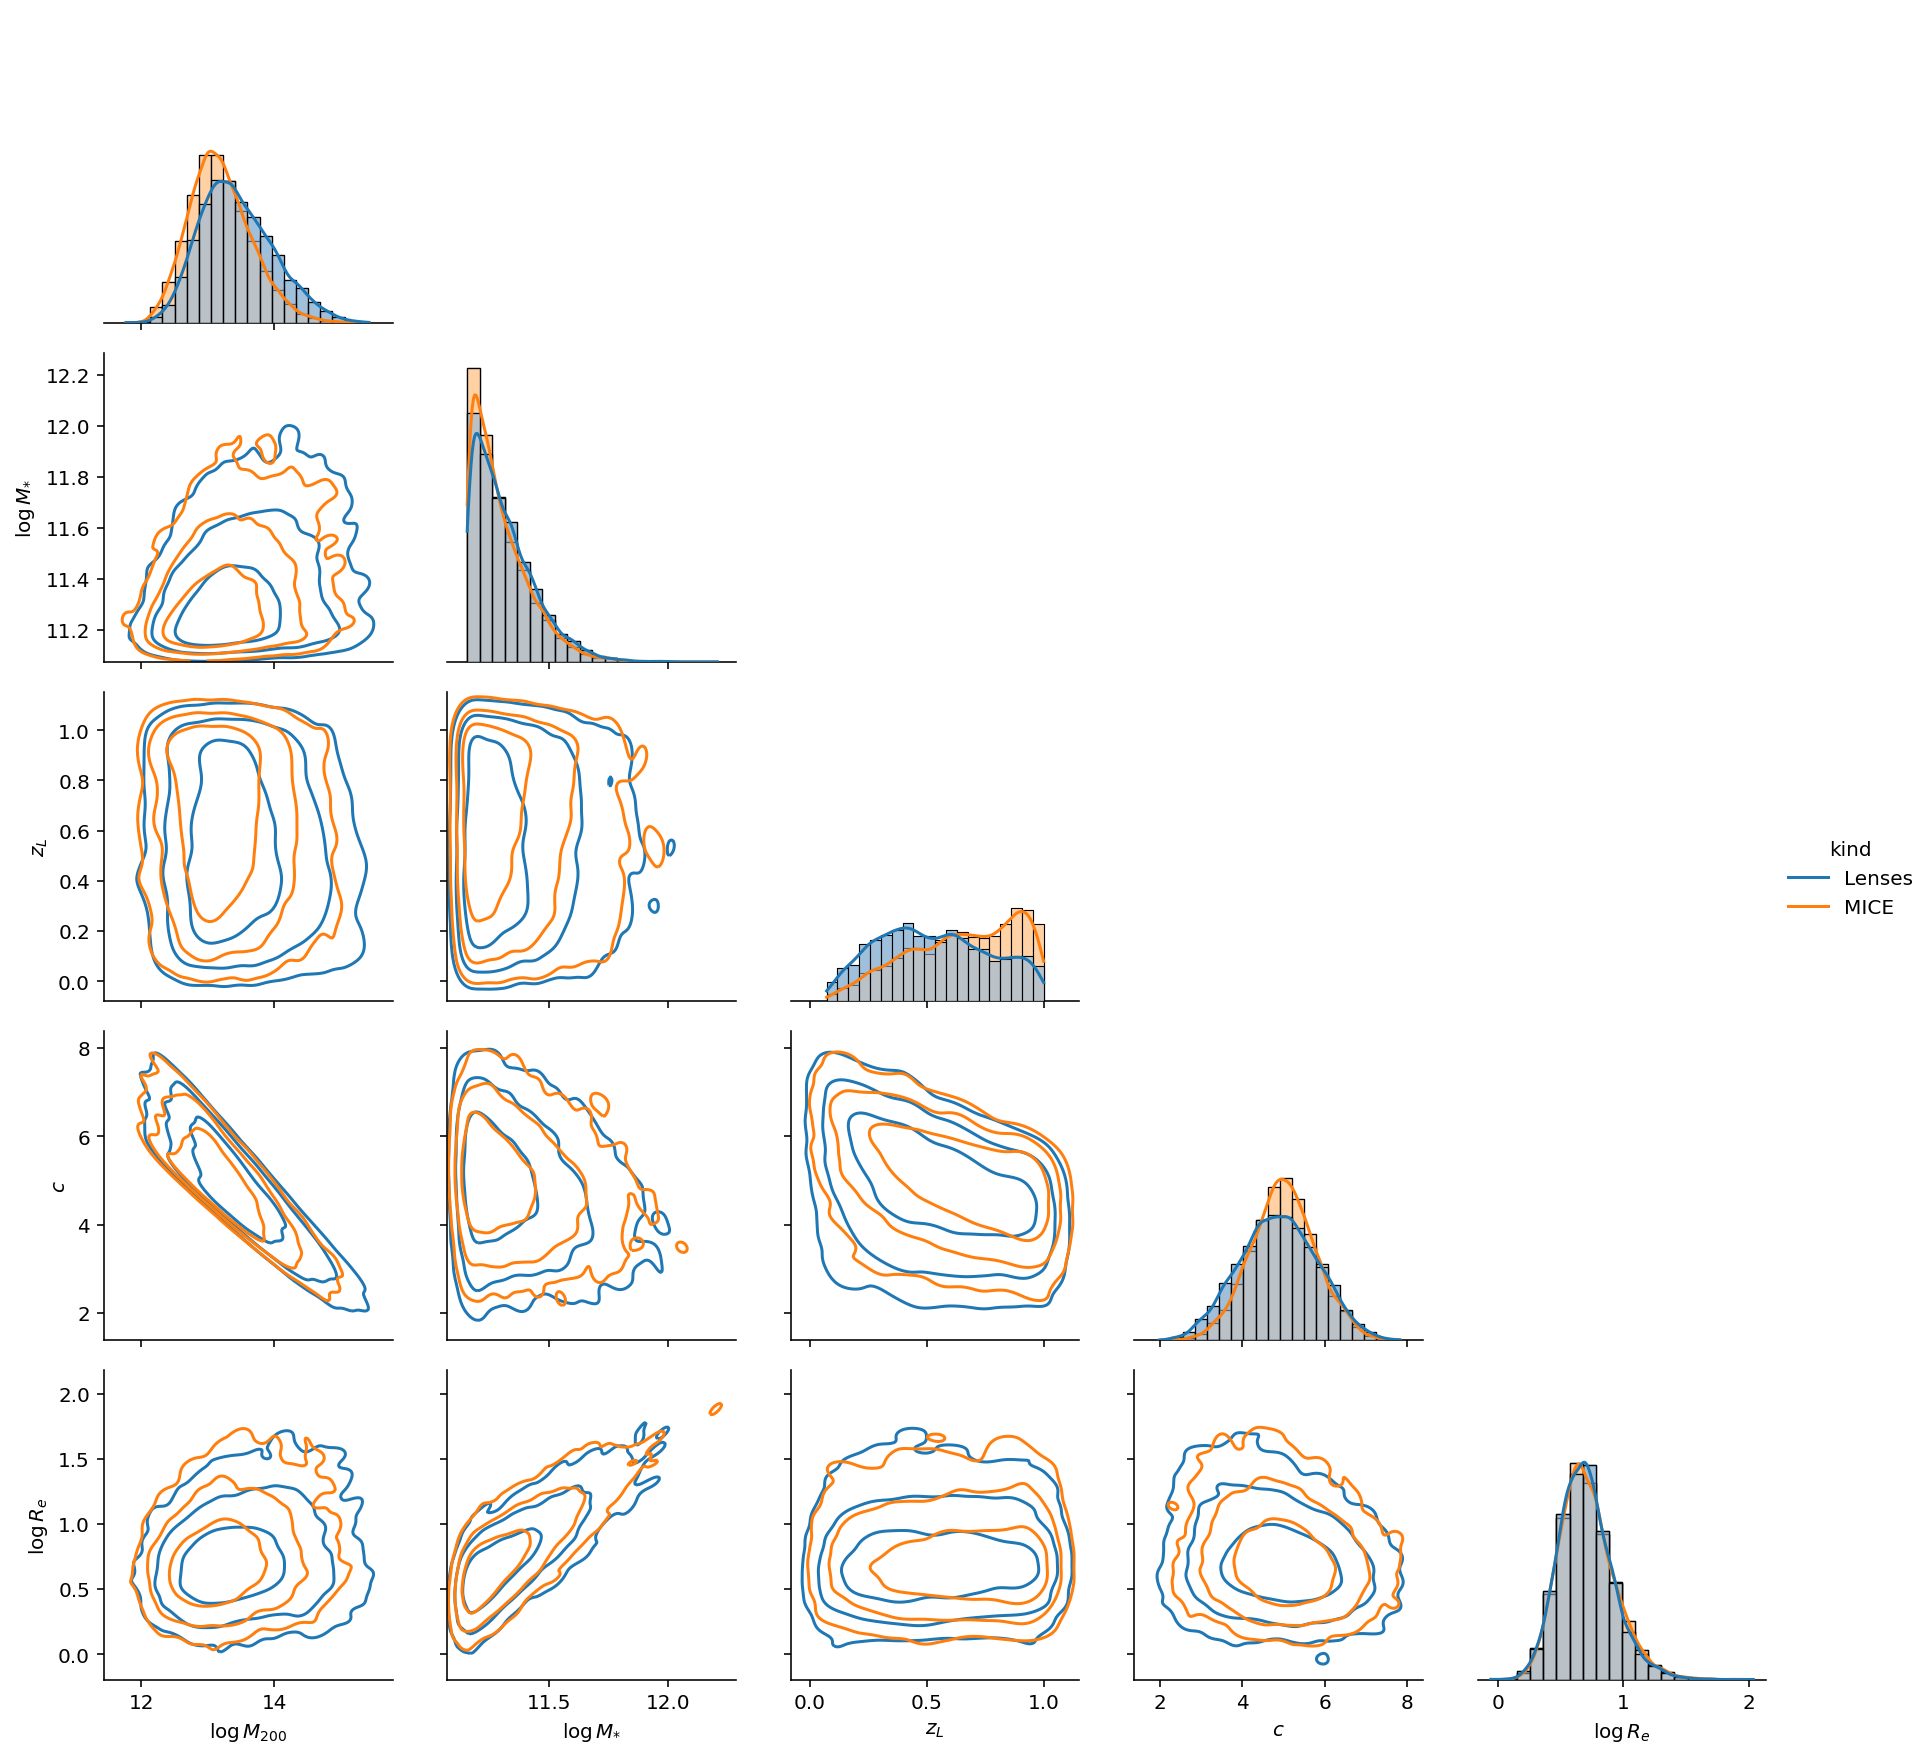

In [5]:
g = sns.PairGrid(df, hue="kind",corner=True)
g.map_lower(sns.kdeplot,levels=[.003,.05,.34])
g.map_diag(sns.histplot,kde=True,bins=20,stat='count')
g.map_diag(sns.histplot,palette=palette,bins=20,stat='count')
g.add_legend()
#g.savefig("./plots/diag1.eps",format='eps',transparent=True)

In [6]:
num = 5
alpha = np.linspace(1.0,1.8,num)
gamma = np.linspace(.8,1.8,num)
Alpha = np.round(np.repeat(alpha,5),2)
Gamma = np.round(np.tile(gamma,5),2)
totnum = []
Args1 = []
Args2 = []
Args3 = []
Args4 = []
for i in range(len(Alpha)):  
    dat = np.fromfile("../Downloads/GLens1/GLens_para/lenses_all/r{}_alpha{}.bin".format(Alpha[i],Gamma[i]),dtype='f8').reshape(-1,8)    
    zlens = dat[:,2]
    einsrad = dat[:,5]
    ind = einsrad > 0
    exp_e = einsrad[ind]
    mo1 = np.mean(exp_e)
    mo2 = np.var(exp_e)
    N = len(einsrad[ind])
    Args1.append(mo1)
    Args2.append(mo2)
    Args3.append(mo2/N)
    Args4.append(np.mean((exp_e-mo1)**4)/N- mo2**2 * (N-3)/(N*(N-1)))
    totnum.append(len(zlens[zlens>0]))

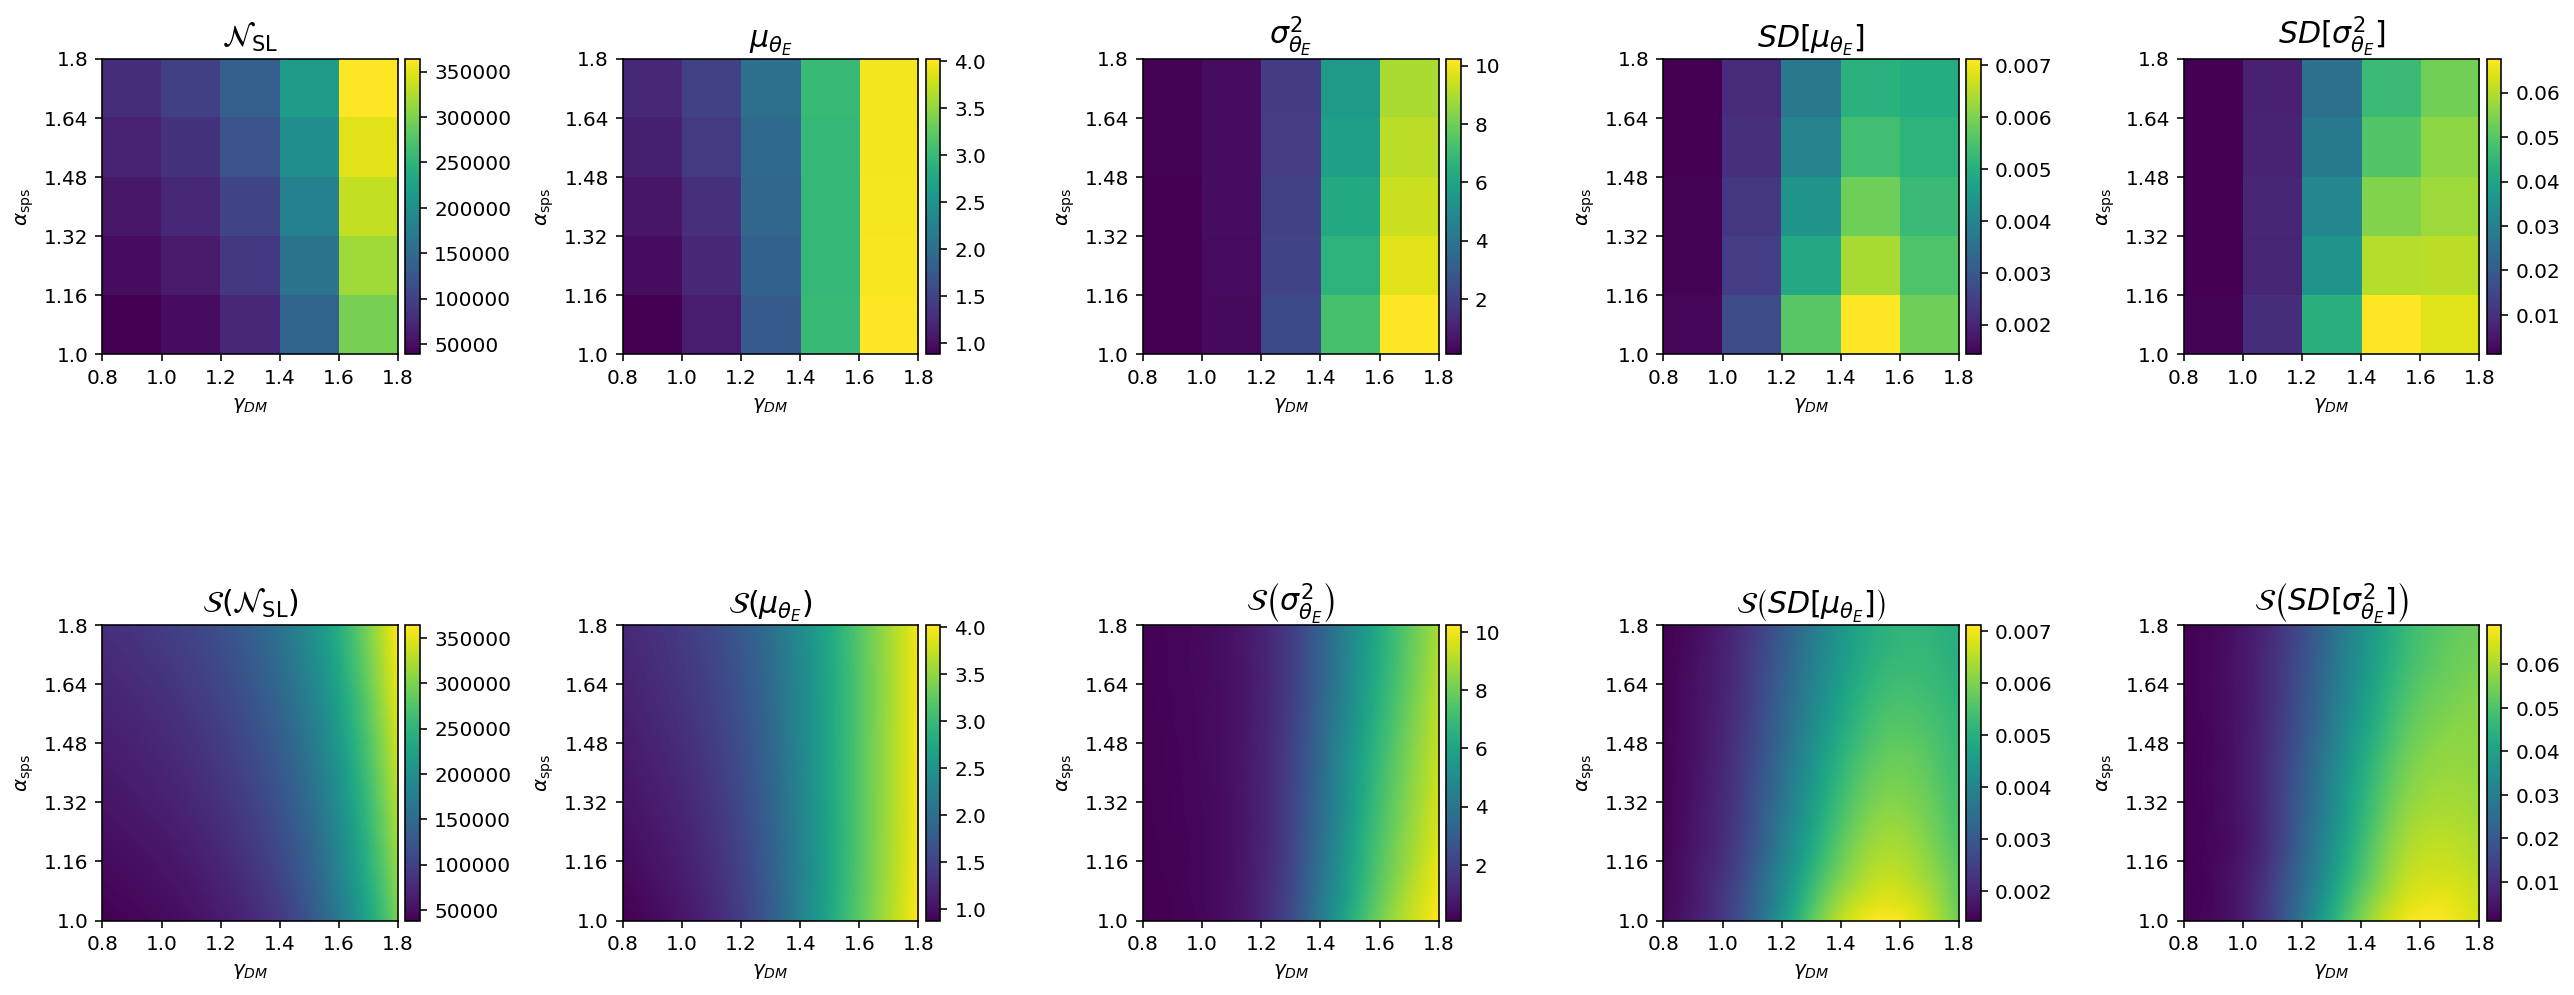

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import LinearNDInterpolator,griddata

totnum = np.asarray(totnum).reshape(len(alpha),len(gamma))
Args1 = np.asarray(Args1).reshape(len(alpha),len(gamma))
Args2 = np.asarray(Args2).reshape(len(alpha),len(gamma))
Args3 = np.asarray(np.sqrt(Args3)).reshape(len(alpha),len(gamma))
Args4 = np.asarray(np.sqrt(Args4)).reshape(len(alpha),len(gamma))

# create a meshgrid
gg,aa = np.meshgrid(gamma,alpha)
# create function of NSL
func2d = LinearNDInterpolator(list(zip(gg.flatten(), aa.flatten())), totnum.flatten())
# create function of mu
func2d_mu = LinearNDInterpolator(list(zip(gg.flatten(), aa.flatten())), Args1.flatten())
# create function of sigma^2
func2d_sig = LinearNDInterpolator(list(zip(gg.flatten(), aa.flatten())), Args2.flatten())
func2d_meanvar = LinearNDInterpolator(list(zip(gg.flatten(), aa.flatten())), Args3.flatten())
func2d_varvar = LinearNDInterpolator(list(zip(gg.flatten(), aa.flatten())), Args4.flatten())
Num_interp = 1000
new_Gamma = np.linspace(.8,1.8,Num_interp)
new_Alpha = np.linspace(1.,1.8,Num_interp)
# a denser meshgrid 
xx,yy = np.meshgrid(new_Gamma,new_Alpha)
# compute values on grid using the functions created above
new_totnum = func2d(xx,yy)
new_mu = func2d_mu(xx,yy)
new_sig = func2d_sig(xx,yy)
new_meanvar = func2d_meanvar(xx,yy)
new_varvar = func2d_varvar(xx,yy)

new_totnum = griddata(list(zip(gg.flatten(), aa.flatten())), totnum.flatten(), list(zip(xx.flatten(), yy.flatten())), method='cubic').reshape(Num_interp,Num_interp)
new_mu = griddata(list(zip(gg.flatten(), aa.flatten())), Args1.flatten(), list(zip(xx.flatten(), yy.flatten())), method='cubic').reshape(Num_interp,Num_interp)
new_sig = griddata(list(zip(gg.flatten(), aa.flatten())), Args2.flatten(), list(zip(xx.flatten(), yy.flatten())), method='cubic').reshape(Num_interp,Num_interp)
new_meanvar = griddata(list(zip(gg.flatten(), aa.flatten())), Args3.flatten(), list(zip(xx.flatten(), yy.flatten())), method='cubic').reshape(Num_interp,Num_interp)
new_varvar = griddata(list(zip(gg.flatten(), aa.flatten())), Args4.flatten(), list(zip(xx.flatten(), yy.flatten())), method='cubic').reshape(Num_interp,Num_interp)
Vals = [totnum,Args1,Args2,Args3,Args4]
Vals_interp = [new_totnum,new_mu,new_sig,new_meanvar,new_varvar]
Vals_title = [r"$\mathcal{N}_{\rm{SL}}$",r"$\mu_{\theta_E}$",r"$\sigma^2_{\theta_E}$",r"${SD[\mu_{\theta_E}]}$",r"${SD[\sigma^2_{\theta_E}]}$"]
Vals_interp_title = [r"$ \mathcal{S}\left(\mathcal{N}_{\rm{SL}}\right)$",r"$\mathcal{S}\left(\mu_{\theta_E}\right)$",r"$\mathcal{S}\left(\sigma^2_{\theta_E}\right)$",r"$\mathcal{S}\left({SD[\mu_{\theta_E}]}\right)$",r"$\mathcal{S}\left({SD[\sigma^2_{\theta_E}]}\right)$"]

fig,ax = plt.subplots(2,5,figsize=(18,8))
for i in range(len(Vals)):
    im1 = ax[0,i].imshow(Vals[i],extent=[-1,1,-1,1],origin='lower')
    ax[0,i].set_xticks(np.linspace(-1,1,6))
    ax[0,i].set_xticklabels(np.round(np.linspace(.8,1.8,6),2))
    ax[0,i].set_yticks(np.linspace(-1,1,6))
    ax[0,i].set_yticklabels(np.round(np.linspace(1.,1.8,6),2))
    divider = make_axes_locatable(ax[0,i])
    cax1 = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax1, orientation='vertical')
    ax[0,i].set_ylabel(r'$\alpha_{\rm{sps}}$')
    ax[0,i].set_xlabel(r'$\gamma_{DM}$')
    ax[0,i].set_title(Vals_title[i],fontsize=15)
    
    im2 = ax[1,i].imshow(Vals_interp[i],extent=[-1,1,-1,1],origin='lower')
    ax[1,i].set_xticks(np.linspace(-1,1,6))
    ax[1,i].set_xticklabels(np.round(np.linspace(.8,1.8,6),2))
    ax[1,i].set_yticks(np.linspace(-1,1,6))
    ax[1,i].set_yticklabels(np.round(np.linspace(1.,1.8,6),2))
    divider = make_axes_locatable(ax[1,i])
    cax2 = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax2, orientation='vertical')
    ax[1,i].set_ylabel(r'$\alpha_{\rm{sps}}$')
    ax[1,i].set_xlabel(r'$\gamma_{DM}$')
    ax[1,i].set_title(Vals_interp_title[i],fontsize=15)





fig.tight_layout()
plt.show()
#fig.savefig("./plots/interp_3.png",format='png')

In [8]:
alpha_truth = 1.2
gamma_truth = 1.3
NSL_obs = int(func2d(gamma_truth,alpha_truth))
mu_obs = func2d_mu(gamma_truth,alpha_truth)
sig_obs = func2d_sig(gamma_truth,alpha_truth)
print("NSL_obs,mu,sig: ",NSL_obs,mu_obs,sig_obs)

NSL_obs,mu,sig:  91206 1.8494822569362506 2.1497838169424694


In [9]:
from scipy.stats import norm, poisson

def probN(x,mu=NSL_obs):
    return poisson.pmf(mu,x)

def probmu(x,mu=mu_obs,sig=.05):
    return np.exp(-(x-mu)**2/(2*sig**2))/(sig*np.sqrt(2*np.pi))


def probsig(x,mu=sig_obs,sig=.05):
    return np.exp(-(x-mu)**2/(2*sig**2))/(sig*np.sqrt(2*np.pi))

def get_levels(Z):
    Z = Z.flatten()
    r1 = np.linspace(Z.min(),Z.max(),10000)
    r_arr = np.asarray([np.sum(Z[Z>r1[i]])/Z.sum() for i in range(len(r1))])
    lv1 = r1[np.argmin(np.abs(r_arr-.68))]
    lv2 = r1[np.argmin(np.abs(r_arr-.95))]
    lv3 = r1[np.argmin(np.abs(r_arr-.997))]
    
    return [lv3,lv2,lv1]
    


Z1 = probN(new_totnum)
Z2 = probmu(x=new_mu,sig=new_meanvar)
Z3 = probsig(x=new_sig,sig=new_varvar)
Z4 = Z1*Z2*Z3
lvs1 = get_levels(Z1)
lvs2 = get_levels(Z2)
lvs3 = get_levels(Z3)
lvs4 = get_levels(Z4)

In [10]:
Num_Z4 = 500
Gamma_Z4 = np.linspace(1.295,1.305,Num_Z4)
Alpha_Z4 = np.linspace(1.18,1.22,Num_Z4)
# a denser meshgrid 
xx_Z4,yy_Z4 = np.meshgrid(Gamma_Z4,Alpha_Z4)
totnum_Z4 = func2d(xx_Z4,yy_Z4)
mu_Z4 = func2d_mu(xx_Z4,yy_Z4)
sig_Z4 = func2d_sig(xx_Z4,yy_Z4)
meanvar_Z4 = func2d_meanvar(xx_Z4,yy_Z4)
varvar_Z4 = func2d_varvar(xx_Z4,yy_Z4)
totnum_Z4 = griddata(list(zip(gg.flatten(), aa.flatten())), totnum.flatten(), list(zip(xx_Z4.flatten(), yy_Z4.flatten())), method='cubic')
mu_Z4 = griddata(list(zip(gg.flatten(), aa.flatten())), Args1.flatten(), list(zip(xx_Z4.flatten(), yy_Z4.flatten())), method='cubic')
sig_Z4 = griddata(list(zip(gg.flatten(), aa.flatten())), Args2.flatten(), list(zip(xx_Z4.flatten(), yy_Z4.flatten())), method='cubic')
meanvar_Z4 = griddata(list(zip(gg.flatten(), aa.flatten())), Args3.flatten(), list(zip(xx_Z4.flatten(), yy_Z4.flatten())), method='cubic')
varvar_Z4 = griddata(list(zip(gg.flatten(), aa.flatten())), Args4.flatten(), list(zip(xx_Z4.flatten(), yy_Z4.flatten())), method='cubic')
Z1_new = probN(totnum_Z4)
Z2_new = probmu(x=mu_Z4,sig=meanvar_Z4)
Z3_new = probsig(x=sig_Z4,sig=varvar_Z4)
Z4_new = Z1_new*Z2_new*Z3_new
lvs1_new = get_levels(Z1_new)
lvs2_new = get_levels(Z2_new)
lvs3_new = get_levels(Z3_new)
lvs4_new = get_levels(Z4_new)

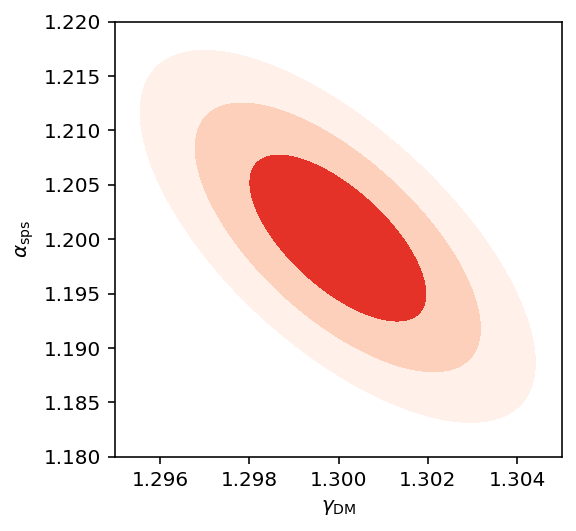

In [11]:
fig,ax = plt.subplots(1,1,figsize=(4,4))
ax.contourf(Gamma_Z4,Alpha_Z4,Z4_new.reshape(500,500),levels=np.concatenate((lvs4_new,Z4_new.max()),axis=None),cmap='Reds')
ax.set_ylabel(r'$\alpha_{\rm{sps}}$')
ax.set_xlabel(r'$\gamma_{\rm{DM}}$')
plt.show()

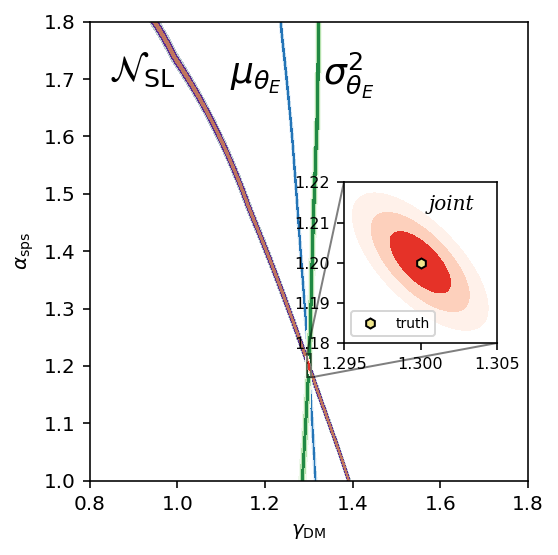

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [34]:
x = new_Gamma
y = new_Alpha
fig,ax = plt.subplots(1,1,figsize=(4,4))
ax.contourf(x,y,Z1,levels=np.concatenate((lvs1,Z1.max()),axis=None),cmap='twilight',zorder=1)
ax.contourf(x,y,Z2,levels=np.concatenate((lvs2,Z2.max()),axis=None),cmap='Blues',zorder=2)
ax.contourf(x,y,Z3,levels=np.concatenate((lvs3,Z3.max()),axis=None),cmap='Greens',zorder=2)
#ax.contourf(x,y,Z4,levels=np.concatenate((lvs4,Z4.max()),axis=None),cmap='Reds',zorder=4)
ax.contourf(Gamma_Z4,Alpha_Z4,Z4_new.reshape(500,500),levels=np.concatenate((lvs4_new,Z4_new.max()),axis=None),cmap='Reds',zorder=4)
ax.text(.92,1.75,r'$\mathcal{N}_{\rm{SL}}$',fontsize=18, style='oblique', ha='center',va='top', wrap=True)
ax.text(1.18,1.73,r'$\mu_{\theta_E}$',fontsize=18, style='oblique', ha='center',va='top', wrap=True)
ax.text(1.39,1.75,r'$\sigma^2_{\theta_E}$',fontsize=18, style='oblique', ha='center',va='top', wrap=True)
ax.set_ylabel(r'$\alpha_{\rm{sps}}$')
ax.set_xlabel(r'$\gamma_{\rm{DM}}$')

axins = ax.inset_axes([0.58, 0.3, 0.35, 0.35])
#axins.contourf(x,y,Z4,levels=np.concatenate((lvs4,Z4.max()),axis=None),cmap='Reds')
axins.contourf(Gamma_Z4,Alpha_Z4,Z4_new.reshape(500,500),levels=np.concatenate((lvs4_new,Z4_new.max()),axis=None),cmap='Reds')
axins.text(1.302,1.217,'joint',fontsize=10, family='serif',style='italic', ha='center',va='top', wrap=True)
axins.plot(gamma_truth,alpha_truth,lw=0,marker='h',color="khaki",mec="k",markersize=5,zorder=2,label="truth")
axins.tick_params(axis='x', labelsize=8) 
axins.tick_params(axis='y', labelsize=8) 
axins.set_xlim([1.295,1.305])
axins.set_ylim([1.18,1.22])
axins.legend(loc=3,fontsize="x-small")

ax.indicate_inset_zoom(axins, edgecolor="black")
fig.tight_layout()
plt.show()
#fig.savefig("/Users/tardis/Desktop/plots/constrain_by_3.eps",format='eps')

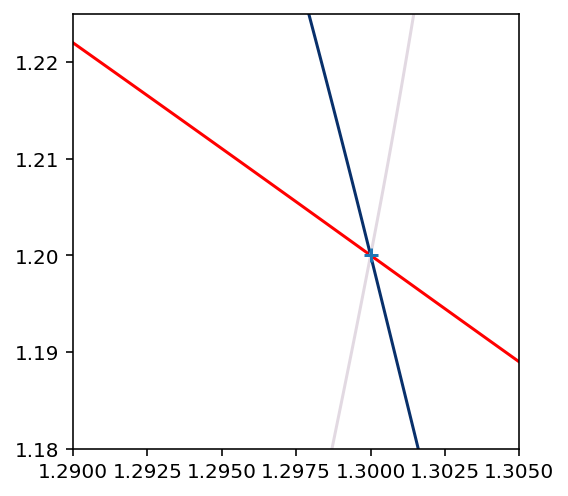

In [13]:
x = new_Gamma
y = new_Alpha
plt.figure(figsize=(4,4))
cs1 = plt.contour(x,y,new_totnum,levels=[NSL_obs],cmap='prism',zorder=1)
cs2 = plt.contour(x,y,new_mu,levels=[mu_obs],cmap='Blues_r',zorder=1)
cs3 = plt.contour(x,y,new_sig,levels=[sig_obs],cmap='twilight',zorder=1)
plt.scatter(gamma_truth,alpha_truth,marker="+",s=50,zorder=2)
plt.xlim([1.29,1.305])
plt.ylim([1.18,1.225])
plt.show()

(1.18, 1.22)

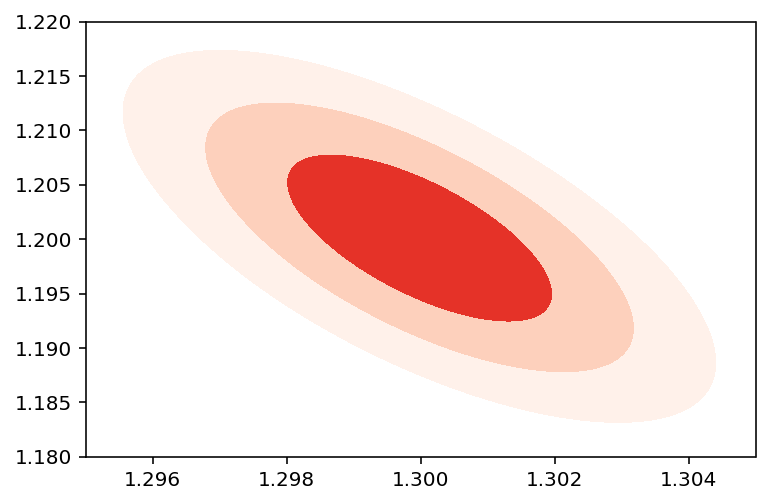

In [14]:
cs = plt.contourf(Gamma_Z4,Alpha_Z4,Z4_new.reshape(500,500),levels=np.concatenate((lvs4_new,Z4_new.max()),axis=None),cmap='Reds')
plt.xlim([1.295,1.305])
plt.ylim([1.18,1.22])

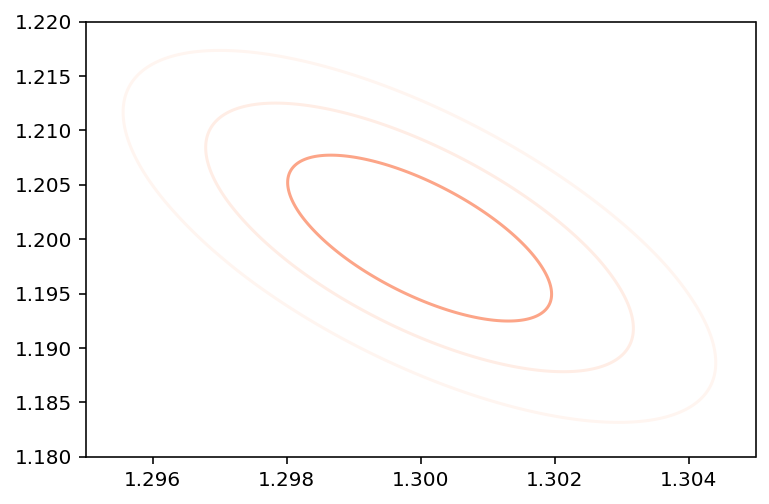

In [15]:
cs = plt.contour(Gamma_Z4,Alpha_Z4,Z4_new.reshape(500,500),levels=np.concatenate((lvs4_new,Z4_new.max()),axis=None),cmap='Reds')
plt.xlim([1.295,1.305])
plt.ylim([1.18,1.22])
path1 = cs.collections[0].get_paths()[0]._vertices
path2 = cs.collections[1].get_paths()[0]._vertices
path3 = cs.collections[2].get_paths()[0]._vertices

1 sigma:  1.2999838580401732 0.001970770229857477 0.001970770229857699 1.2000978980623482 0.00762816435182434 0.00762816435182434
3 sigma:  1.2999809467628887 0.004425364486841499 0.004425364486841499 1.2002542712750843 0.017105745257287364 0.017105745257287364


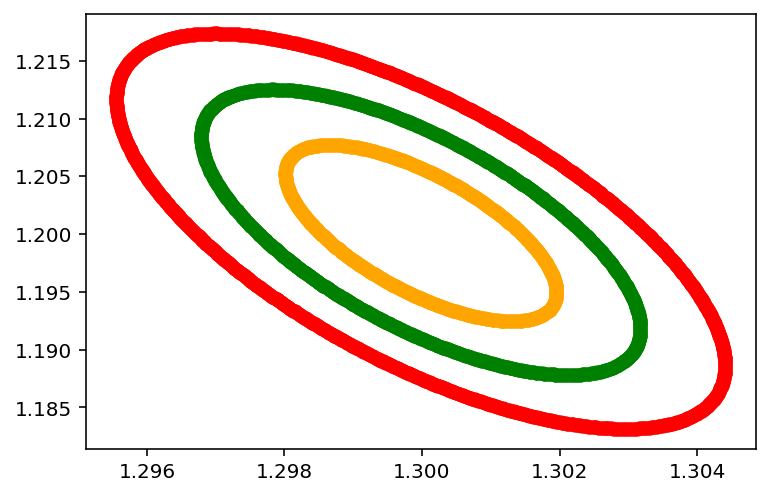

In [14]:
plt.scatter(path1[:,0],path1[:,1],color='red')
plt.scatter(path2[:,0],path2[:,1],color='green')
plt.scatter(path3[:,0],path3[:,1],color='orange')
xmin1 = path3[:,0].min();xmax1 = path3[:,0].max()
ymin1 = path3[:,1].min();ymax1 = path3[:,1].max()
xmin3 = path1[:,0].min();xmax3 = path1[:,0].max()
ymin3 = path1[:,1].min();ymax3 = path1[:,1].max()
xmean1 = .5*(xmin1+xmax1)
ymean1 = .5*(ymin1+ymax1)
xmean3 = .5*(xmin3+xmax3)
ymean3 = .5*(ymin3+ymax3)
print("1 sigma: ",xmean1,xmean1-xmin1,xmax1-xmean1,ymean1,ymean1-ymin1,ymax1-ymean1)
print("3 sigma: ",xmean3,xmean3-xmin3,xmax3-xmean3,ymean3,ymean3-ymin3,ymax3-ymean3)

In [16]:
NSL_obs,mu_obs,sig_obs

(91206, array(1.84948226), array(2.14978382))

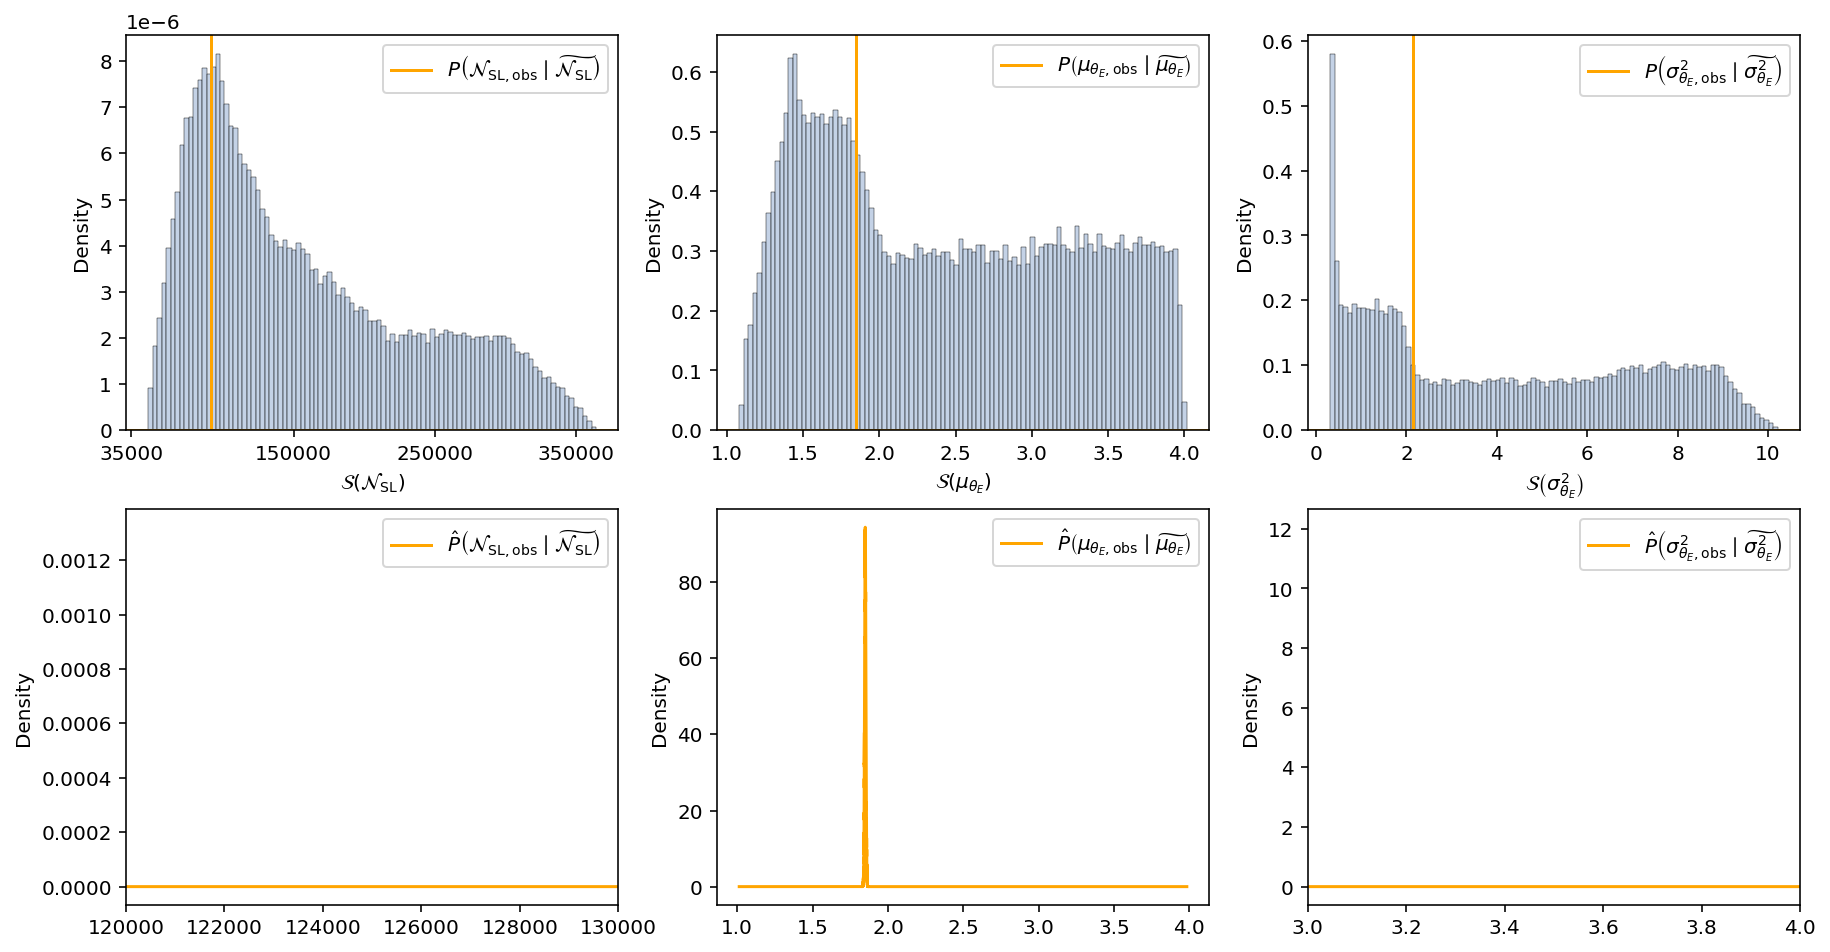

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [17]:
from scipy.signal import unit_impulse

N = 100000
alpha_random = np.random.uniform(1.,1.8,N)
gamma_random = np.random.uniform(.8,1.8,N)
N_random = func2d(alpha_random,gamma_random)
mu_random = func2d_mu(alpha_random,gamma_random)
sig_random = func2d_sig(alpha_random,gamma_random)

N_rd_random = np.round(N_random)
xplot = [NSL_obs,mu_obs,sig_obs]
rand_plot = [N_rd_random,mu_random,sig_random]
title_plot = [r"$\mathcal{S}\left(\mathcal{N}_{\rm{SL}}\right)$",r"$\mathcal{S}\left(\mu_{\theta_E}\right)$",r"$\mathcal{S}\left(\sigma^2_{\theta_E}\right)$"]
lb_plot = [r"$P\left(\mathcal{N}_{\rm{SL,obs}}\mid\widetilde{\mathcal{N}_{\rm{SL}}}\right)$",r"$P\left(\mu_{\theta_E,\rm{obs}}\mid\widetilde{\mu_{\theta_E}}\right)$",r"$P\left(\sigma^2_{\theta_E,\rm{obs}}\mid\widetilde{\sigma^2_{\theta_E}}\right)$"]
lb_plot_est = [r"$\hat{P}\left(\mathcal{N}_{\rm{SL,obs}}\mid\widetilde{\mathcal{N}_{\rm{SL}}}\right)$",r"$\hat{P}\left(\mu_{\theta_E,\rm{obs}}\mid\widetilde{\mu_{\theta_E}}\right)$",r"$\hat{P}\left(\sigma^2_{\theta_E,\rm{obs}}\mid\widetilde{\sigma^2_{\theta_E}}\right)$"]
Xval_plot = [new_totnum.flatten(),new_mu.flatten(),new_sig.flatten()]
Yval_plot = [Z1.flatten(),Z2.flatten(),Z3.flatten()]

fig,ax = plt.subplots(2,3,figsize=(15,8))
for i in range(3):
    sns.histplot(rand_plot[i],bins=100,stat='density',ax=ax[0,i],color='lightsteelblue')
    ax[0,i].axvline(x=xplot[i],color='orange',label=lb_plot[i])
    ax[0,i].axhline(y=0,color='orange')
    ax[0,i].set_xlabel(title_plot[i])
    #ind1 = int(len(new_totnum.flatten())/3):int(len(new_totnum.flatten())/2)
    ind2 = np.argsort(Xval_plot[i][int(len(new_totnum.flatten())/3):int(len(new_totnum.flatten())/2)] )
    ax[1,i].plot(Xval_plot[i][int(len(new_totnum.flatten())/3):int(len(new_totnum.flatten())/2)][ind2],Yval_plot[i][int(len(new_totnum.flatten())/3):int(len(new_totnum.flatten())/2)][ind2],color='orange',label=lb_plot_est[i])
    #ax[1,i].plot(Xval_plot[i][:100],Yval_plot[i][:100],color='orange',label=lb_plot_est[i])
    ax[0,i].set_xlabel(title_plot[i])
    ax[1,i].set_ylabel('Density')
    ax[0,i].legend()
    ax[1,i].legend()
    if i == 0:
        ax[1,i].set_xlim([120000,130000])
        ax[0,i].set_xticks([35000,150000,250000,350000])
        ax[0,i].set_xticklabels([35000,150000,250000,350000])
    if i == 2:
        ax[1,i].set_xlim([3,4])
        
    
plt.show()
fig.tight_layout()
#fig.savefig("/Users/tardis/Desktop/plots/likelihoods.eps",format='eps')